# Face It.. We'hv got feelings EDA

In [ ]:
#!pip install numpy pandas matplotlib tensorflow scikit-learn

In [4]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Flatten, Dense, Activation, Input, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/fer2013.csv'

In [5]:
df = pd.read_csv(file_path)
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


In [7]:
df.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [8]:
df.shape

(35887, 3)

In [9]:
print(df['emotion'].value_counts())

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


In [10]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


### Convert Pixels Column to Images

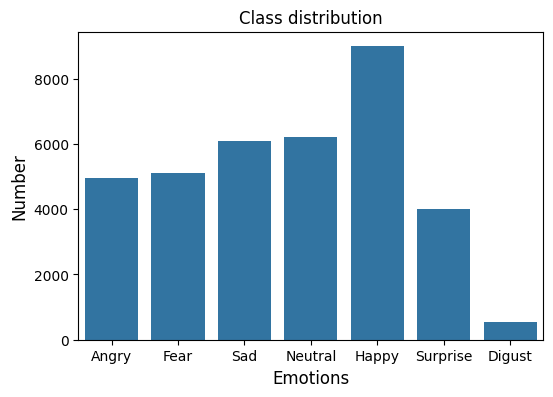

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x='emotion', y='number', data=emotion_counts)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

### Visualize Sample Images

In [12]:
df['emotion'] = df['emotion'].rank(method='dense').astype(int) - 1

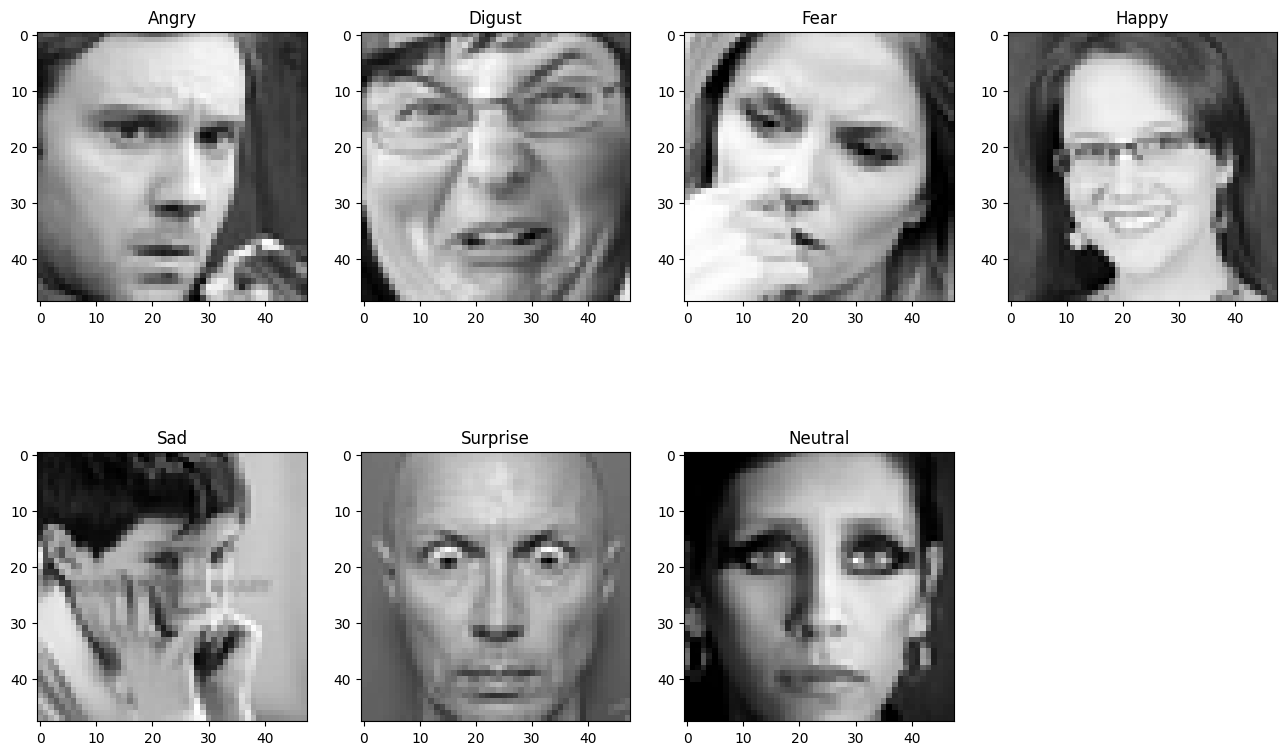

In [13]:
def row2image(row):
    pixels = np.array([int(p) for p in row['pixels'].split()]).reshape(48,48)
    label = emotion_map[row['emotion']]
    return pixels, label

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0], cmap='gray')
    plt.title(img[1])

plt.show()

### Preprocess data

In [14]:
data_train = df[df['Usage']=='Training'].copy()
data_val   = df[df['Usage']=='PublicTest'].copy()
data_test  = df[df['Usage']=='PrivateTest'].copy()

# Check shapes
print("Train shape: {}, \nValidation shape: {}, \nTest shape: {}".format(
    data_train.shape, data_val.shape, data_test.shape))

Train shape: (28709, 3), 
Validation shape: (3589, 3), 
Test shape: (3589, 3)


In [15]:
data_train.emotion.value_counts()

,count
emotion,
3,7215
6,4965
4,4830
2,4097
0,3995
5,3171
1,436


In [16]:
num_classes = 7
width, height = 48, 48
num_epochs = 100
batch_size = 64

In [17]:
def CRNO(df, dataName):
    def process_pixels(pixel_sequence):
        if isinstance(pixel_sequence, str):  # FER2013 CSV case
            return [int(pixel) for pixel in pixel_sequence.split()]
        else:  # Already list/array
            return pixel_sequence

    df['pixels'] = df['pixels'].apply(process_pixels)

    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, width, height, 1) / 255.0
    data_Y = to_categorical(df['emotion'], num_classes)

    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    return data_X, data_Y

In [18]:
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (28709, 48, 48, 1) train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1) val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1) test _Y shape: (3589, 7)


### Define the CNN Model

In [19]:
    #VGG-16 Model
def Emotion_Baseline():
  model = Sequential()
  model.add(Input(shape=(48,48,1)))

  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  # Block 2
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  # Block 3
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  # Block 4 (This code is added to improve performance)
  model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  # Dense layers
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation='relu'))   #Neurons increased
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))

  # # Compile
  # model.compile(
  #   optimizer=Adam(learning_rate=1e-4),
  #   loss='categorical_crossentropy',
  #   metrics=['accuracy']
  # )
  return model
model = Emotion_Baseline()

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,224,647 (19.93 MB)

 Trainable params: 5,220,679 (19.92 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
# from tensorflow.keras.optimizers.schedules import CosineDecay
# initial_learning_rate = 1e-4
# lr_schedule = CosineDecay(initial_learning_rate, decay_steps=num_epochs)

In [21]:
#Compile the model

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_X)

In [23]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(train_Y, axis=1)),
    y=np.argmax(train_Y, axis=1)
)
class_weights = dict(enumerate(class_weights))

In [24]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [25]:
history = model.fit(
    datagen.flow(train_X, train_Y, batch_size=batch_size),
    epochs=num_epochs,
    validation_data=(val_X, val_Y),
    callbacks=[es,reduce_lr],
    class_weight=class_weights
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.1597 - loss: 2.7679 - val_accuracy: 0.0730 - val_loss: 3.1175 - learning_rate: 1.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.1649 - loss: 2.5498 - val_accuracy: 0.1502 - val_loss: 2.3066 - learning_rate: 1.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.1805 - loss: 2.3738 - val_accuracy: 0.1772 - val_loss: 2.3860 - learning_rate: 1.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.1970 - loss: 2.2769 - val_accuracy: 0.1825 - val_loss: 2.4183 - learning_rate: 1.0000e-04
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.2208 - loss: 2.1258 - val_accuracy: 0.1914 - val_loss: 3.0099 - learning_rate: 1.0000e-04
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.2550 - loss: 2.0186 - val_accuracy: 0.3087 - val_loss: 1.8229 - learning_rate: 1.0000e-04
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - a

In [26]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")

113/113 - 1s - 9ms/step - accuracy: 0.6336 - loss: 0.9739
Test Accuracy: 63.36%


In [27]:
def plot_training(results):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- Accuracy ---
    acc = results.history.get('accuracy', results.history.get('acc'))
    val_acc = results.history.get('val_accuracy', results.history.get('val_acc'))

    axes[0].plot(acc, label='Train Accuracy')
    axes[0].plot(val_acc, label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    # --- Loss ---
    axes[1].plot(results.history['loss'], label='Train Loss')
    axes[1].plot(results.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.show()

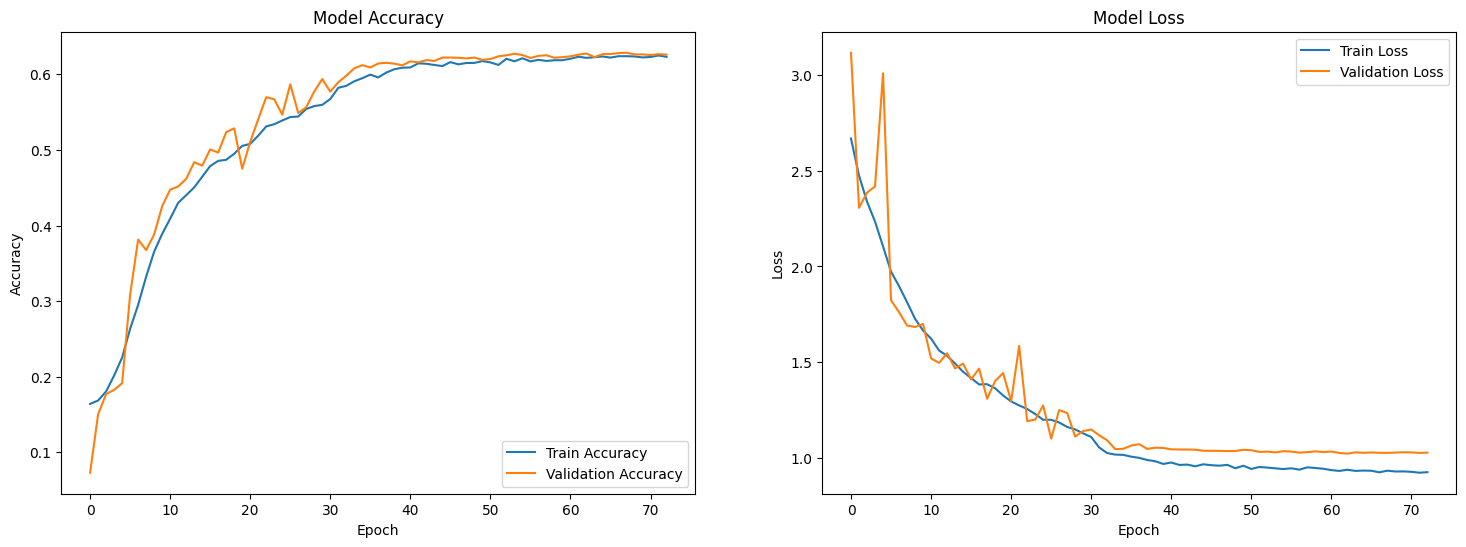

In [28]:
plot_training(history)

In [29]:
import tensorflow as tf
model.save('DeepS_emotion_model.keras')

In [37]:
import os
#Create a path to save the model on Google drive
file_path = '/content/drive/My Drive/Emotion_model/'


# Create the directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

# Save the model
model.save(os.path.join(file_path, 'DeepS_emotion_model.keras'))
print("Model saved to Google Drive.")

Model saved to Google Drive.


In [38]:
import tensorflow as tf

# Define the path to the unzipped model directory
model_directory = '/content/drive/My Drive/Emotion_model/DeepS_emotion_model.keras'
# Load the model from the directory
loaded_model = tf.keras.models.load_model(model_directory)

print("Model loaded successfully.")

Model loaded successfully.


In [74]:
file_path = '/content/drive/My Drive/Emotion_model/Sample_Images/Three.png'

In [44]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
if os.path.exists(file_path):
    print("File exists on disk. Proceeding to check if it's readable.")
else:
    print("File does NOT exist. Please re-check the path or upload the file.")

File exists on disk. Proceeding to check if it's readable.


In [75]:
# 1. Load the image in grayscale
new_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

if new_image is not None:
    # 2. Resize the image to match your model's input size (e.g., 48x48)
    resized_image = cv2.resize(new_image, (48, 48))

    # 3. Reshape the image to add the channel and batch dimensions
    # For a grayscale image, the shape should be (1, 48, 48, 1)
    reshaped_image = np.expand_dims(resized_image, axis=-1)
    final_input = np.expand_dims(reshaped_image, axis=0)

    # 4. Normalize the pixel values (if you did this during training)
    final_input = final_input / 255.0

    print("Image preprocessed successfully.")
else:
    print("Error: The image could not be read by OpenCV.")

Image preprocessed successfully.


In [76]:
predictions = loaded_model.predict(final_input)

# Get the predicted class index (the one with the highest probability)
predicted_class_index = np.argmax(predictions)

# Use your emotion_map to get the emotion label
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
predicted_emotion = emotion_map[predicted_class_index]

# Get the confidence score
confidence = np.max(predictions) * 100

print(f"The model predicted the emotion: {predicted_emotion}")
print(f"Prediction confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The model predicted the emotion: Fear
Prediction confidence: 32.27%
